ARIMA MODEL NO DECOMP OR DIFFERNCING PRIOR TO RUNNING

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
#filepath
NYT_file="../Potential Data Sources/NYT- Cty Cases Deaths Thru Oct2/us-counties.csv"

#read dataset
NYT=pd.read_csv(NYT_file, parse_dates=['date'])

# limit dataset to texas
Texas=NYT.loc[NYT['state']=='Texas'].dropna(how='any', axis=0)
Texas2=Texas.drop(['fips', 'state'], axis=1)

### pick a county
CtyName='Harris'
CountyChoice=Texas2.loc[Texas2['county']==CtyName].set_index('date')
CountyChoice2=CountyChoice.drop('county', axis=1)

# CountyChoice2=Texas2
CountyChoice2

,cases,deaths
date,,
2020-03-05,4,0
2020-03-06,5,0
2020-03-07,5,0
2020-03-08,6,0
2020-03-09,6,0
...,...,...
2020-09-29,142315,2588
2020-09-30,142681,2599
2020-10-01,143530,2607


In [3]:
#param analysis for ARIMA model:
data=CountyChoice2['cases']

# Split data into train / test sets 
# Isolate only the transformed data into a dataframe for the model

# split test train 
end_train=pd.to_datetime('2020-07-31')
start_test=pd.to_datetime('2020-08-01')
train=data[:end_train]
test=data[start_test:]
print(train.shape, test.shape)

(149,) (64,)


In [4]:
# Import the library 
from pmdarima import auto_arima 
  
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(train, start_p = 1, start_q = 1, 
                          max_p = 10, max_q = 30, m = 2, #monthly
                          start_P = 0, seasonal = True, 
                          stationary=True,
                          trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 
x=stepwise_fit.get_params()
    
# override Q parameter if 0 to 1
so=x['seasonal_order']
so_slice1=so[ :2]
if so[2]==0:
    so=so_slice1+ (1, 2)

print(x)
print(so)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=2217.319, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=3373.878, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=3458.057, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=2308.546, Time=0.13 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=2137.321, Time=0.29 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=2152.432, Time=0.21 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=2147.806, Time=0.36 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=2191.836, Time=0.24 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=2139.215, Time=0.25 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=2132.235, Time=0

In [5]:
# Fit a SARIMAX(1,0,1)(2,0,0,12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train,
                order = (x['order']),
                seasonal_order =(so),
                initialization='approximate_diffuse')
  
result = model.fit() 
result.summary() 

C:\Users\track\anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\track\anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\track\anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             cases   No. Observations:                  149
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 2)   Log Likelihood               -1054.216
Date:                           Tue, 20 Oct 2020   AIC                           2118.432
Time:                                   12:56:50   BIC                           2133.451
Sample:                               03-05-2020   HQIC                          2124.534
                                    - 07-31-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9994      0.043     23.128      0.000       0.915       1.084
ma.L1          0.1830      0.056      3.278      0.001       0.074       0.292
ar.S.L2        0.9987      0.086     11.557      0.000       0.829       1.168
ma.S.L2       -0.6225      0.070     -8.857      0.000      -0.760      -0.485
sigma2      7.921e+04   5418.280     14.619      0.000    6.86e+04    8.98e+04
===================================================================================
Ljung-Box (Q):                       76.70   Jarque-Bera (JB):               313.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              17.16   Skew:                             0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

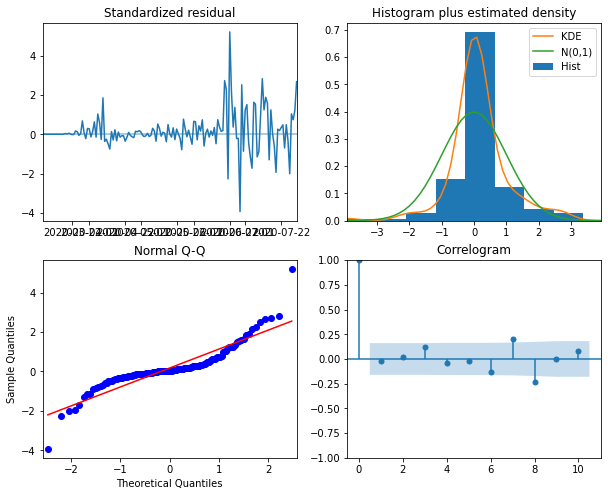

In [6]:
result.plot_diagnostics(figsize=(10,8));

<AxesSubplot:xlabel='date'>

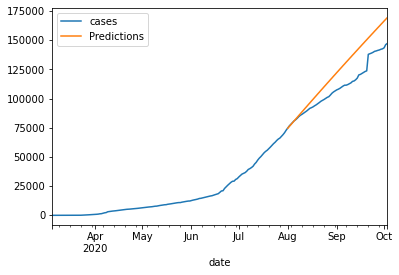

In [7]:
# compare test train
start = len(train) 
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end).rename("Predictions") 
  
# plot predictions and actual values 
data.plot(legend = True)
predictions.plot(legend = True)

In [8]:
predictions

2020-08-01     74584.274236
2020-08-02     76186.237262
2020-08-03     77716.656234
2020-08-04     79314.449168
2020-08-05     80840.794685
                  ...      
2020-09-29    163618.954467
2020-09-30    165034.436814
2020-10-01    166514.772838
2020-10-02    167926.407874
2020-10-03    169402.811384
Freq: D, Name: Predictions, Length: 64, dtype: float64

In [9]:
#  get results for full dataset:
end=pd.to_datetime('2020-10-03')
start=pd.to_datetime('2020-04-01')
formodel=data[start:end]

#   cases_best_training_model for full data
stepwise_fit_full = auto_arima(formodel, start_p = 1, start_q = 1, 
                                max_p = 10, max_q = 30, m = 2,
                                start_P = 0, seasonal = True, 
                                stationary=True,
                                trace = True, 
                                error_action ='ignore',   # we don't want to know if an order does not work 
                                suppress_warnings = True,  # we don't want convergence warnings 
                                stepwise = True)           # set to stepwise

# pull out the parameters of the best model for this county
x_full=stepwise_fit_full.get_params()
    
# override Q parameter if 0 to 1
so_full=x_full['seasonal_order']
so_full_slice1=so_full[ :2]
if so_full[2]==0:
    so_full=so_full_slice1+ (1, 2)

print(x_full)
print(so_full)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=4528.494, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=4676.239, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[2] intercept   : AIC=4450.594, Time=0.04 sec
 ARIMA(0,0,0)(2,0,0)[2] intercept   : AIC=4451.177, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=4381.435, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[2] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(2,0,1)[2] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(1,0,2)[2] intercept   : AIC=4367.757, Time=0.06 sec
 ARIMA(0,0,0)(0,0,2)[2] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(2,0,2)[2] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=3171.166, Time=0.33 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=3209.708, Time=0.23 sec
 AR

In [10]:
# runs model with best fit ARIMA params
full_model = SARIMAX(formodel,
                order = (x_full['order']),
                seasonal_order =(x_full['seasonal_order']),
                initialization='approximate_diffuse')

full_result = full_model.fit()

full_result.summary()

C:\Users\track\anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\track\anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               cases   No. Observations:                  186
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 2)   Log Likelihood               -1563.540
Date:                             Tue, 20 Oct 2020   AIC                           3135.080
Time:                                     12:56:58   BIC                           3147.983
Sample:                                 04-01-2020   HQIC                          3140.308
                                      - 10-03-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.044     22.556      0.000       0.913       1.087
ar.S.L2        0.9999      0.097     10.299      0.000       0.810       1.190
ma.S.L2       -0.8997      0.094     -9.571      0.000      -1.084      -0.715
sigma2       1.16e+06   5.78e+04     20.059      0.000    1.05e+06    1.27e+06
===================================================================================
Ljung-Box (Q):                       12.66   Jarque-Bera (JB):            102474.57
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):             100.27   Skew:                             9.56
Prob(H) (two-sided):                  0.00   Kurtosis:                       116.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
# Getting 120 days (a little more than 6 months in business days) for forecasts
SARIMAX_forecast = round(full_result.forecast(steps = 90))

idx = pd.date_range('2020-10-04', '2021-01-01', freq='d')
 
SARIMAX_forecast = pd.DataFrame(list(zip(list(idx),list(SARIMAX_forecast))),
columns=['Date','Forcast Cases']).set_index('Date')


SARIMAX_forecast

,Forcast Cases
Date,
2020-10-04,148169.0
2020-10-05,149790.0
2020-10-06,150661.0
2020-10-07,152282.0
2020-10-08,153153.0
...,...
2020-12-28,254228.0
2020-12-29,255094.0
2020-12-30,256709.0


(18353.0, 18627.0)

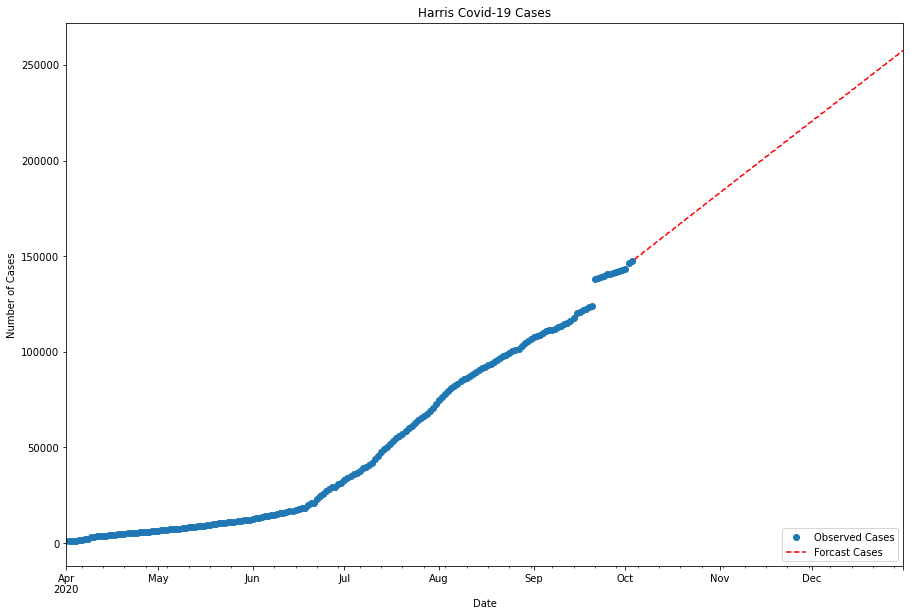

In [12]:
# Graph
fig, ax = plt.subplots(figsize=(15,10))
npre = 4
ax.set(title= f'{CtyName} Covid-19 Cases', xlabel='Date', ylabel='Number of Cases')


# Plot data points
data.loc['2020-04-01':].plot(ax=ax, style='o', label='Observed Cases')

# Plot predictions
SARIMAX_forecast.loc['2020-10-03':].plot(ax=ax, style='r--', label='Sarimax forecast')

# predict.predicted_mean.loc['2020-04-01':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
# ci = predict_ci.loc['2020-04-01':]
# ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
# predict_dy.predicted_mean.loc['2020-04-01':].plot(ax=ax, style='g', label='Dynamic forecast')
# ci = predict_dy_ci.loc['2020-04-01':]
# ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)


legend = ax.legend(loc='lower right')
ax.set_xlim(np.datetime64('2020-04-01'), np.datetime64('2020-12-31'))